# A short tutorial on Fuzzy Time Series - Part II (with an case study on Solar Energy)

[MINDS - Machine Intelligence and Data Science Lab  ](http://www.minds.eng.ufmg.br/)

Petrônio C.  L. Silva, Rodrigo C. P. Silva, Marcos A. Alves, Carlos A. Severiano Jr.,   Gustavo L. Vieira, Frederico G. Guimarães, Hossein J. Sadaei

<center>
<table><tr><td> <a href="http://www.minds.eng.ufmg.br/"><img src="https://github.com/petroniocandido/pyFTS/raw/master/img/minds_logo_medium.jpeg" alt="MINDS - Machine Intelligence and Data Science Lab" width="100"/></a></td> 
  <td>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;</td>
<td><a href="https://pyfts.github.io/pyFTS/"><img src="https://github.com/petroniocandido/pyFTS/raw/master/img/logo_medium.png" alt="pyFTS - Fuzzy Time Series for Python" width="100"/></a></td>
</tr>
</table>
</center>


## Environment Setup

In [0]:
!pip3 install -U git+https://github.com/PYFTS/pyFTS

  Cloning https://github.com/PYFTS/pyFTS to /tmp/pip-req-build-wb95cf55
  Running command git clone -q https://github.com/PYFTS/pyFTS /tmp/pip-req-build-wb95cf55
  Stored in directory: /tmp/pip-ephem-wheel-cache-7sosnbbf/wheels/e7/32/a9/230470113df5a73242a5a6d05671cb646db97abf14bbce2644
Successfully built pyFTS


In [0]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib as plt
import matplotlib.pyplot as plt

from pyFTS.common import Util
from pyFTS.benchmarks import Measures
from pyFTS.partitioners import Grid,  Entropy #, Huarng
from pyFTS.models import hofts
from pyFTS.common import Membership


## Testing the parameters

### Test data

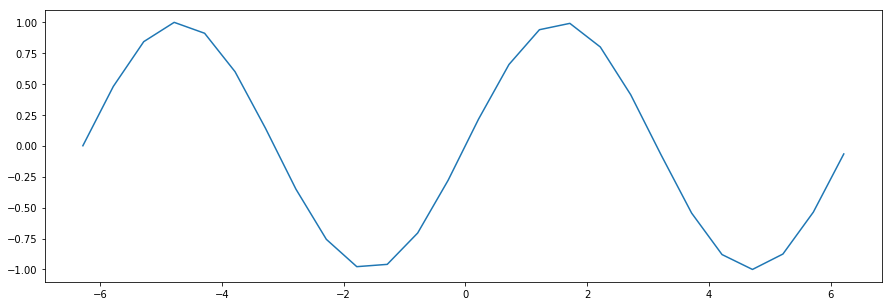

In [0]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=[15,5])


x = [k for k in np.arange(-2*np.pi, 2*np.pi, 0.5)]
y = [np.sin(k) for k in x]

ax.plot(x, y)

### Partitioning

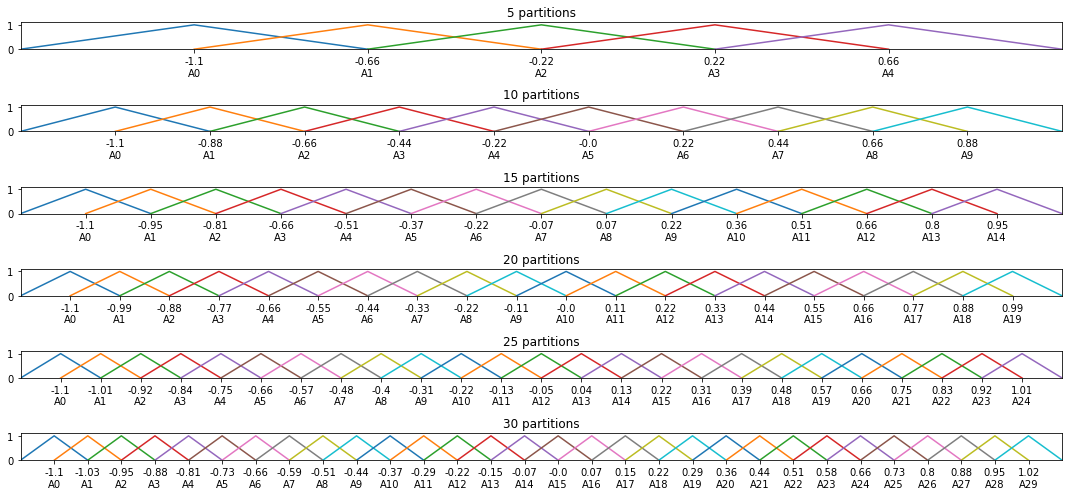

In [0]:
from pyFTS.models import hofts
from pyFTS.partitioners import Grid
from pyFTS.benchmarks import Measures
rows = []

fig, ax = plt.subplots(nrows=6, ncols=1,figsize=[15,7])


for ct, npart in enumerate(np.arange(5,35,5)):
  part = Grid.GridPartitioner(data=y, npart=npart)
  part.name = str(npart) + " partitions"
  
  part.plot(ax[ct], rounding=2)
 
plt.tight_layout()

,Partitions,RMSE,MAPE,U
0,5,0.50,92.31,1.48
1,10,0.37,94.19,1.09
2,15,0.35,101.67,1.01
3,20,0.32,91.33,0.92
4,25,0.30,99.30,0.86
5,30,0.25,76.15,0.72


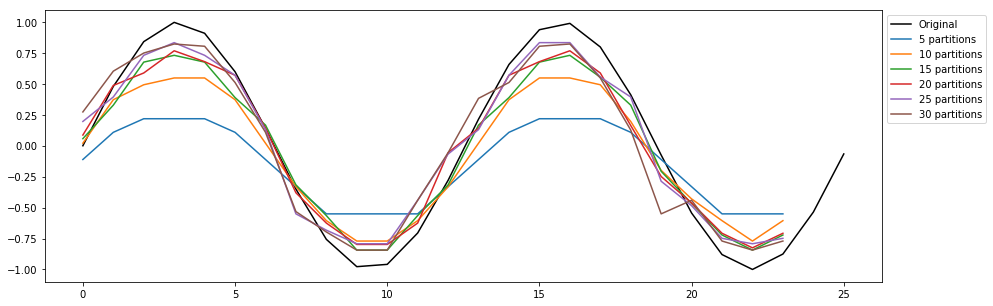

In [0]:
from pyFTS.models import hofts
from pyFTS.partitioners import Grid
from pyFTS.benchmarks import Measures
rows = []


fig, ax = plt.subplots(nrows=1, ncols=1,figsize=[15,5])

ax.plot(y, label='Original',color='black')

for npart in np.arange(5,35,5):
  part = Grid.GridPartitioner(data=y, npart=npart)
  model = hofts.HighOrderFTS(order=1, partitioner=part)
  model.fit(y)
  forecasts = model.predict(y)
    
  ax.plot(forecasts[:-1], label=str(npart) + " partitions")
  
  rmse, mape, u = Measures.get_point_statistics(y, model)
  
  rows.append([npart, rmse, mape, u])
  

handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc=2, bbox_to_anchor=(1, 1))

pd.DataFrame(rows, columns=['Partitions','RMSE','MAPE','U'])

### Order

,Order,RMSE,MAPE,U
0,1,0.37,94.19,1.09
1,2,0.12,27.30,0.34
2,3,0.07,15.70,0.22


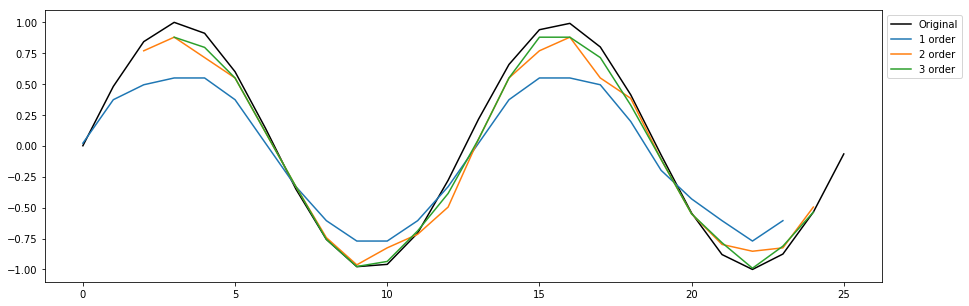

In [0]:
from pyFTS.models import hofts
from pyFTS.partitioners import Grid
from pyFTS.benchmarks import Measures
rows = []

fig, ax = plt.subplots(nrows=1, ncols=1,figsize=[15,5])

ax.plot(y, label='Original',color='black')

for order in np.arange(1,4):
  part = Grid.GridPartitioner(data=y, npart=10)
  model = hofts.HighOrderFTS(order=order, partitioner=part)
  model.fit(y)
  forecasts = model.predict(y)
  if order > 1:
    for k in np.arange(order):
      forecasts.insert(0,None)

  ax.plot(forecasts[:-1], label=str(order) + " order")
  
  rmse, mape, u = Measures.get_point_statistics(y, model)
  
  rows.append([order, rmse, mape, u])
  

handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc=2, bbox_to_anchor=(1, 1))

pd.DataFrame(rows, columns=['Order','RMSE','MAPE','U'])

### Method

,Model,RMSE,MAPE,U
0,HOFTS,0.37,94.19,1.09
1,WHOFTS,0.35,103.61,1.01
2,PWFTS,0.34,107.11,0.99


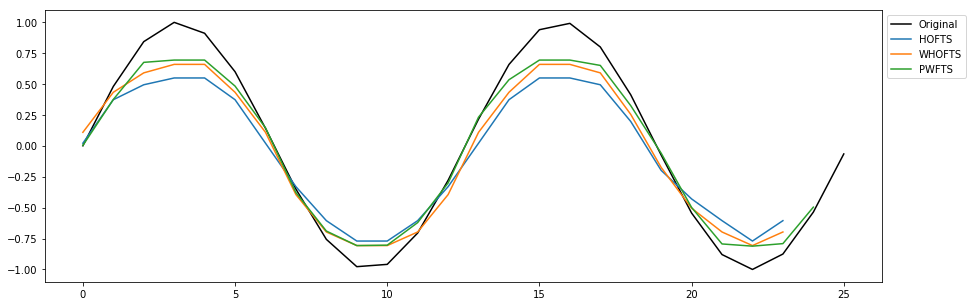

In [0]:
from pyFTS.models import hofts, pwfts
from pyFTS.partitioners import Grid
from pyFTS.benchmarks import Measures
rows = []

fig, ax = plt.subplots(nrows=1, ncols=1,figsize=[15,5])

ax.plot(y, label='Original',color='black')

part = Grid.GridPartitioner(data=y, npart=10)

for method in [hofts.HighOrderFTS, hofts.WeightedHighOrderFTS, pwfts.ProbabilisticWeightedFTS]:
  model = method(order=1, partitioner=part)
  model.fit(y)
  forecasts = model.predict(y)

    
  ax.plot(forecasts[:-1], label=model.shortname)
  
  rmse, mape, u = Measures.get_point_statistics(y, model)
  
  rows.append([model.shortname, rmse, mape, u])
  

handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc=2, bbox_to_anchor=(1, 1))

pd.DataFrame(rows, columns=['Model','RMSE','MAPE','U'])

## Case Study: Solar Energy

In [0]:
models = []

### Data

In [0]:
dataset = pd.read_csv('https://query.data.world/s/2bgegjggydd3venttp3zlosh3wpjqj', sep=';')

dataset['data'] = pd.to_datetime(dataset["data"], format='%Y-%m-%d %H:%M:%S')

train_uv = dataset['glo_avg'].values[:24505]
test_uv = dataset['glo_avg'].values[24505:]

train_mv = dataset.iloc[:24505]
test_mv = dataset.iloc[24505:]

dataset.head()

,data,glo_avg
0,2012-01-01 00:00:00,-1.341817
1,2012-01-01 01:00:00,-1.552517
2,2012-01-01 02:00:00,-1.635200
3,2012-01-01 03:00:00,-2.072400
4,2012-01-01 04:00:00,-1.590400


#### Plots

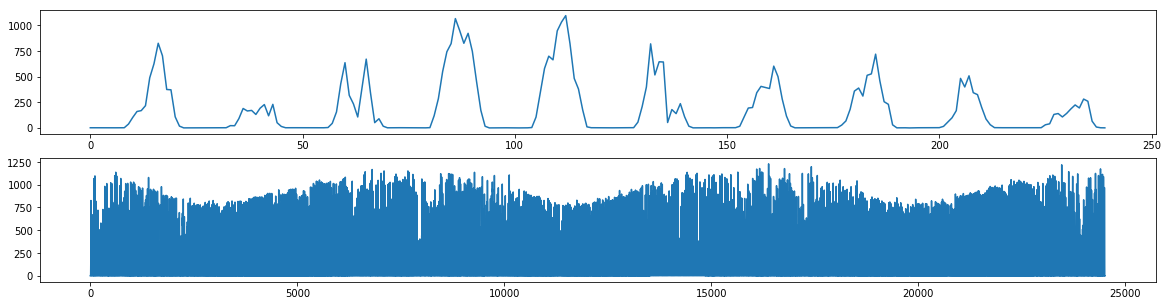

In [0]:
fig, ax = plt.subplots(nrows=2, ncols=1,figsize=[20,5])

ax[0].plot(train_uv[:240])
ax[1].plot(train_uv)

#### ACF

Text(0.5, 0, 'LAG')

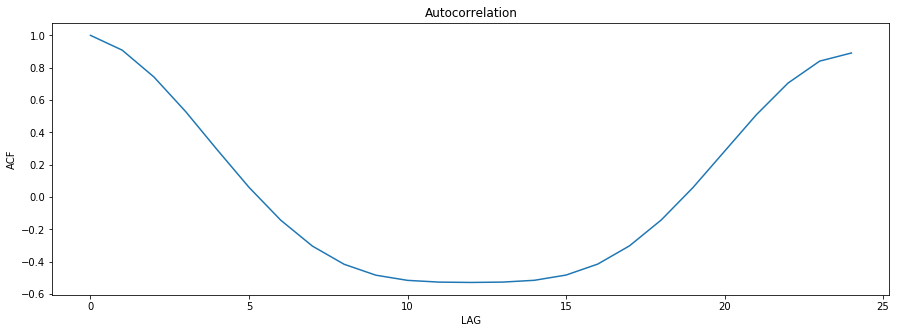

In [0]:
from statsmodels.tsa.stattools import acf

fig, ax = plt.subplots(nrows=1, ncols=1,figsize=[15,5])

ax.plot(acf(train_uv,nlags=24))
ax.set_title("Autocorrelation")
ax.set_ylabel("ACF")
ax.set_xlabel("LAG")

### Monovariate Models

#### Partitioning

In [0]:
from itertools import product

levels = ['VL','L','M','H','VH']
sublevels = [str(k) for k in np.arange(0,7)]
names = []
for combination in product(*[levels, sublevels]):
  names.append(combination[0]+combination[1])
  
print(names)

['VL0', 'VL1', 'VL2', 'VL3', 'VL4', 'VL5', 'VL6', 'L0', 'L1', 'L2', 'L3', 'L4', 'L5', 'L6', 'M0', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'H0', 'H1', 'H2', 'H3', 'H4', 'H5', 'H6', 'VH0', 'VH1', 'VH2', 'VH3', 'VH4', 'VH5', 'VH6']


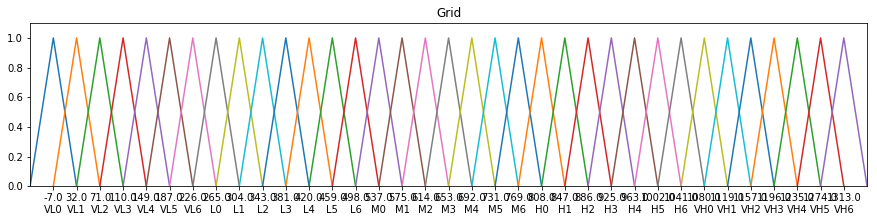

In [0]:
from pyFTS.partitioners import Grid

fig, ax = plt.subplots(nrows=1, ncols=1,figsize=[15,3])

part = Grid.GridPartitioner(data=train_uv,npart=35, names=names)

part.plot(ax)

#### Model Training 

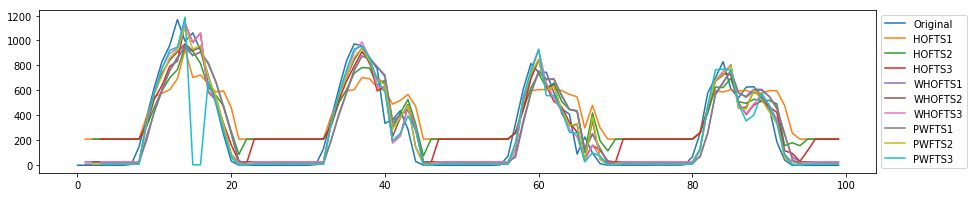

In [0]:
from pyFTS.models import hofts, pwfts

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15,3])


ax.plot(test_uv[:100], label='Original')
rows = []
for method in [hofts.HighOrderFTS, hofts.WeightedHighOrderFTS, pwfts.ProbabilisticWeightedFTS]:
  for order in [1, 2,3]:
    model = method(partitioner=part, order=order)

    model.shortname += str(order)

    model.fit(train_uv)

    forecasts = model.predict(test_uv)

    for k in np.arange(order):
      forecasts.insert(0,None)

    ax.plot(forecasts[:100], label=model.shortname)

    models.append(model.shortname)

    Util.persist_obj(model, model.shortname)

    del(model)

handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc=2, bbox_to_anchor=(1, 1))


    

### Multivariate Models 

#### Variables and Partitioning

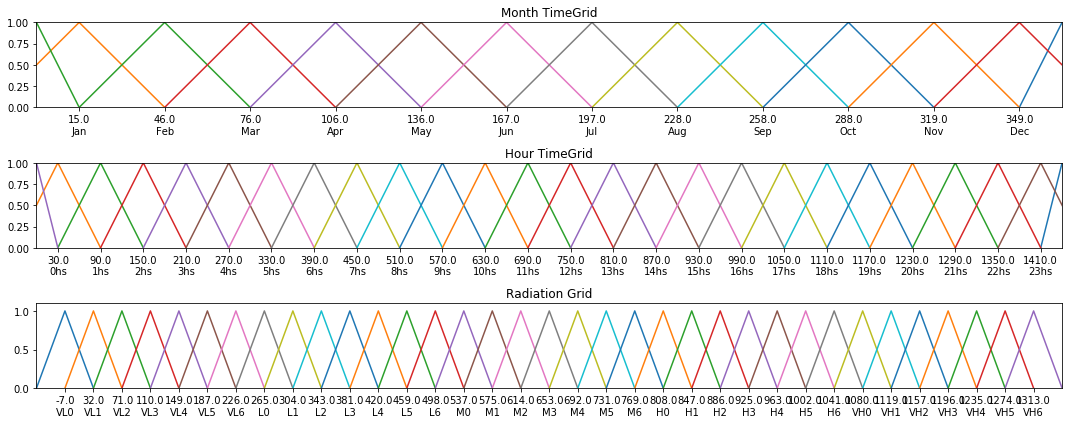

In [0]:
from pyFTS.models.multivariate import common, variable, mvfts
from pyFTS.models.seasonal import partitioner as seasonal
from pyFTS.models.seasonal.common import DateTime

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=[15,6])


sp = {'seasonality': DateTime.day_of_year , 'names': ['Jan','Feb','Mar','Apr','May',
                                                      'Jun','Jul', 'Aug','Sep','Oct',
                                                      'Nov','Dec']}

vmonth = variable.Variable("Month", data_label="data", partitioner=seasonal.TimeGridPartitioner, npart=12, 
                           data=train_mv, partitioner_specific=sp)

vmonth.partitioner.plot(ax[0])


sp = {'seasonality': DateTime.minute_of_day, 'names': [str(k)+'hs' for k in range(0,24)]}

vhour = variable.Variable("Hour", data_label="data", partitioner=seasonal.TimeGridPartitioner, npart=24, 
                          data=train_mv, partitioner_specific=sp)

vhour.partitioner.plot(ax[1])

vavg = variable.Variable("Radiation", data_label="glo_avg", alias='rad',
                         partitioner=Grid.GridPartitioner, npart=35, partitioner_specific={'names': names},  
                         data=train_mv) 

vavg.partitioner.plot(ax[2])

plt.tight_layout()

#### Model Training 

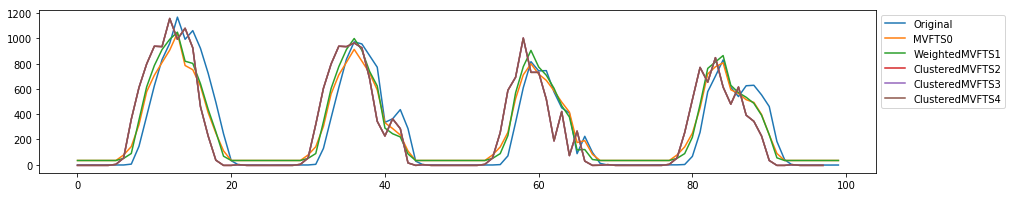

In [0]:
from pyFTS.models.multivariate import mvfts, wmvfts, cmvfts, grid

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15,3])

parameters = [
    {},{},
    {'order':2, 'knn': 1},
    {'order':2, 'knn': 2},
    {'order':2, 'knn': 3},
]

ax.plot(test_uv[:100],label='Original')

for ct, method in enumerate([mvfts.MVFTS, wmvfts.WeightedMVFTS, 
                             cmvfts.ClusteredMVFTS,cmvfts.ClusteredMVFTS,cmvfts.ClusteredMVFTS]):
  try:
    if method != cmvfts.ClusteredMVFTS:
      model = method(explanatory_variables=[vmonth, vhour, vavg], target_variable=vavg, **parameters[ct])
    else:
      fs = grid.GridCluster(explanatory_variables=[vmonth, vhour, vavg], target_variable=vavg)
      model = method(explanatory_variables=[vmonth, vhour, vavg], target_variable=vavg, partitioner=fs, **parameters[ct])
      
    model.shortname += str(ct)
    model.fit(train_mv)

    models.append(model.shortname)

    forecasts = model.predict(test_mv.iloc[:100])

    ax.plot(forecasts[:100], label=model.shortname)
    
    Util.persist_obj(model, model.shortname)

    del(model)
  except Exception as ex:
    print(method, parameters[ct])
    print(ex)


handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc=2, bbox_to_anchor=(1, 1))


### Model Ranking 

In [0]:
rows = []
for file in models:
  try:
    model = Util.load_obj(file)

    row = [model.shortname, model.order,len(model)]

    if model.is_multivariate:
      rmse,_,_ = Measures.get_point_statistics(test_mv, model)
      row.append(rmse)
    else:
      rmse,_,_ = Measures.get_point_statistics(test_uv, model)
      row.append(rmse)

    rows.append(row)
  except:
    pass
pd.DataFrame(rows,columns=["Model","Order","Size","RMSE"]).sort_values(["RMSE","Size"])

,Model,Order,Size,RMSE
10,WeightedMVFTS1,1,3291,87.38
9,MVFTS0,1,3291,93.89
5,WHOFTS3,3,11214,103.17
7,PWFTS2,2,824,105.89
4,WHOFTS2,2,824,106.69
11,ClusteredMVFTS2,2,24809,108.13
12,ClusteredMVFTS3,2,24809,108.13
13,ClusteredMVFTS4,2,24809,108.13
8,PWFTS3,3,11214,111.73
6,PWFTS1,1,33,130.28


### Prediction for the next 48 hours

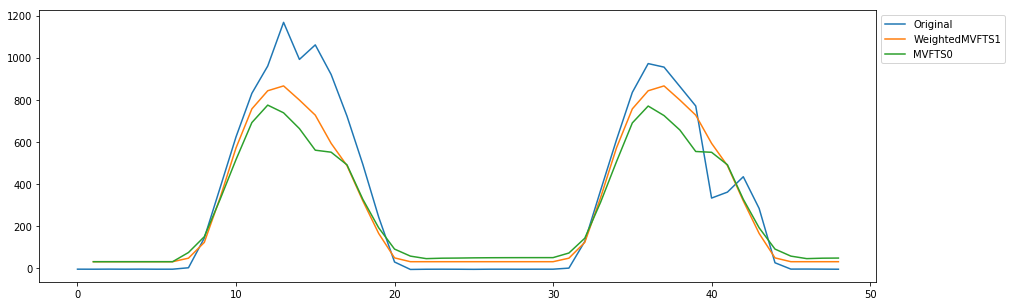

In [0]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15,5])

ax.plot(test_uv[:49],label='Original')


generator = lambda x : x + pd.to_timedelta(1, unit='h') 

for file in ['WeightedMVFTS1', 'MVFTS0']:
  try:
    model = Util.load_obj(file)

    forecasts = model.predict(test_mv.iloc[:1], steps_ahead=48, 
                              generators={'data': generator})

    for k in np.arange(model.order):
      forecasts.insert(0,None)

    ax.plot(forecasts, label=model.shortname)
  except Exception as ex:
    print(ex)
  
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc=2, bbox_to_anchor=(1, 1))